<a href="https://colab.research.google.com/github/verneh/tattoos/blob/main/tattoo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Experiment with Tattoo Removal

In [1]:
!git clone https://github.com/vijishmadhavan/SkinDeep.git SkinDeep

fatal: destination path 'SkinDeep' already exists and is not an empty directory.


In [2]:
cd SkinDeep

/content/SkinDeep


In [3]:
!pip install -r colab_requirements.txt

In [9]:
import fastai
from fastai.vision import *
from fastai.utils.mem import *
from fastai.vision import open_image, load_learner, image, torch
import numpy as np
import urllib.request
import PIL.Image
from io import BytesIO
import torchvision.transforms as T
from PIL import Image
import requests
from io import BytesIO
import fastai
from fastai.vision import *
from fastai.utils.mem import *
from fastai.vision import open_image, load_learner, image, torch
import numpy as np
import urllib.request
import PIL.Image
from io import BytesIO
import torchvision.transforms as T

In [5]:
# define class.
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [6]:
model_URL = "https://www.dropbox.com/s/vxgw0s7ktpla4dk/SkinDeep2.pkl?dl=1"
urllib.request.urlretrieve(model_URL, "SkinDeep2.pkl")
path = Path(".")
learn=load_learner(path, 'SkinDeep2.pkl')

For the sake of the example, let's take a look at David Beckham.

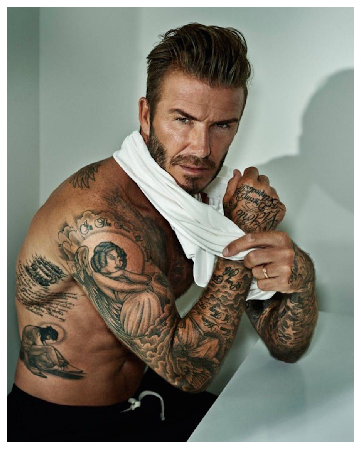

In [10]:
url = 'https://i.pinimg.com/originals/b6/87/ab/b687ab36daf35ce0f31ee78587a295d5.jpg' #@param {type:"string"}

response = requests.get(url)
img = PIL.Image.open(BytesIO(response.content)).convert("RGB")
img_t = T.ToTensor()(img)
img_fast = Image(img_t)
show_image(img_fast, figsize=(8,8), interpolation='nearest');


Now, let's remove David Beckham's tattoos.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


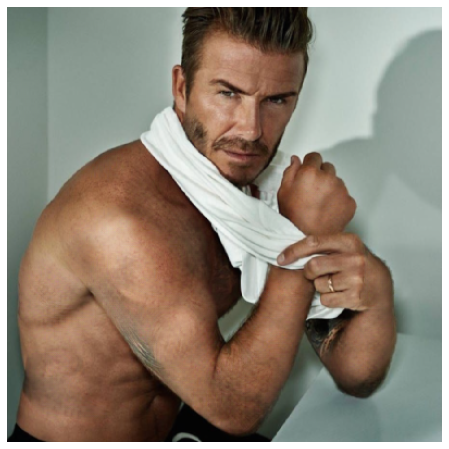

In [11]:
p,img_hr,b = learn.predict(img_fast)
Image(img_hr).show(figsize=(8,8))